In [ ]:
#default_exp core.cult

In [ ]:
#export
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from cmaes import CMA
import os
import numpy as np
import copy

from cult.core.models import FCEncoder, FCDecoder, CNNEncoder, CNNDecoder, EnvironmentInference
from cult.core.utils import rec_likelihood, disable_gradient, kl_div_stdnorm, euclidean, show_batch, save_model, load_model
from cult.config import DATA_PATH, LOG_PATH, PARAM_PATH

In [ ]:
#hide
from cult.core.datasets.moving_mnist import CommonMNIST, CommonFashionMNIST, MovingMNIST, MovingFashionMNIST, FixedMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import datetime as dt
from tqdm import tqdm

In [ ]:
batch_size = 64

In [ ]:
#hide
mnist_data = CommonMNIST(DATA_PATH, transform=ToTensor(), download=True)
mnist_loader = DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
mnist_batch, _ = iter(mnist_loader).next()
small_fashion = CommonFashionMNIST(DATA_PATH, transform=ToTensor())
sf_loader = DataLoader(small_fashion, batch_size=batch_size, shuffle=True)
sf_batch, _ = iter(sf_loader).next()
fashion_data = MovingFashionMNIST(DATA_PATH, transform=ToTensor(), download=True)
fashion_loader = DataLoader(fashion_data, batch_size, shuffle=True)
fashion_batch, _, _ = iter(fashion_loader).next()
mm_data = MovingMNIST(DATA_PATH, transform=ToTensor(), download=True)
mm_loader = DataLoader(mm_data, batch_size, shuffle=True)
mm_batch, _, _ = iter(mm_loader).next()

mnist_test = CommonMNIST(DATA_PATH, transform=ToTensor(), train=False, download=True)
mnist_test_loader =  DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

fashion_test = CommonFashionMNIST(DATA_PATH, transform=ToTensor(), train=False, download=True)
fashion_test_loader = DataLoader(fashion_test, batch_size=batch_size, shuffle=True)


# Continually Learning Variational Autoencoder
> Performs unsupervised continual representation learning with generative replay and environment likelihood detection

Notes: assumes sequential tasks - "local stationarity" i.e. will stay on distribution long enough to learn it

In [ ]:
#export
class CULT(nn.Module):
    def __init__(self, 
        encoder_type: type,
        decoder_type: type,
        final_size: int, 
        latents: int,
        max_envs: int,
        atyp_min: float,
        atyp_max: float,
        env_optim: type,
        env_lr: float,
        env_epochs: int,
        replay_batch_size: int,
        device: str,
    ):
        super().__init__()
        self.latents = latents
        self.max_envs = max_envs
        self.final_size = final_size
        self.atyp_min = atyp_min
        self.atyp_max = atyp_max
        self.device = device
        self.encoder = encoder_type(self.latents, device=self.device)
        self.decoder = decoder_type(self.latents, self.max_envs, device=self.device)
        self.old_encoder = encoder_type(self.latents, device=self.device)
        self.old_decoder = decoder_type(self.latents, self.max_envs, device=self.device)
        self.copy_and_freeze()
        self.encoder.to(self.device), self.decoder.to(self.device), self.old_encoder.to(self.device), self.old_decoder.to(self.device)
        self.replay_batch_size = replay_batch_size
        self.env_net = EnvironmentInference(self.max_envs, self.final_size)
        self.env_net.to(self.device)
        self.env_optim = env_optim(params=self.env_net.parameters(), lr=env_lr)
        self.env_loss = nn.CrossEntropyLoss()
        self.env_epochs = env_epochs
       
        self.m = -1
        self.steps = 0
        self.learning = False

    def forward(self, x):
        batch_size = x.shape[0]
        self.steps += 1

        x_halu, s_halu = self.sample_old()
        
        mu, logvar, final = self.encoder(x)

        if not self.training:
            z = mu 
            s = torch.argmax(self.env_net(final)[:, 0:self.m+1], dim=1)
            rec_x = self.decoder(z, self.int_to_vec(s, batch_size))
            atyp = self.get_atyp(z)
            mu_halu_old, logvar_halu_old, final_halu_old = self.old_encoder(x_halu)
            mu_halu, logvar_halu, final_halu = self.encoder(x_halu)
            rec_x_halo = self.decoder(mu_halu, s_halu)
            return rec_x, mu, logvar, x_halu, rec_x_halo, mu_halu_old, mu_halu, s_halu, atyp
        
        s = self.m if self.m != -1 else 0
        z = self.reparam(mu, logvar)
        rec_x = self.decoder(z, self.int_to_vec(s, batch_size))

        atyp = self.get_atyp(z)

        if self.m == -1:
            if atyp > self.atyp_max:
                self.m = 0
                self.learning = True
        
        elif self.learning:
            if atyp < self.atyp_min:
                self.learning = False
        
        elif atyp > self.atyp_max:
            self.learning = True
            self.m += 1
            if self.m > self.max_envs:
                print("Warning: too many environments")
            self.copy_and_freeze()
        
        
        with torch.no_grad():
            mu_halu_old, logvar_halu_old, final_halu_old = self.old_encoder(x_halu)
            z_halu_old = self.reparam(mu_halu_old, logvar_halu_old)
        
        mu_halu, logvar_halu, final_halu = self.encoder(x_halu)
        z_halu = self.reparam(mu_halu, logvar_halu)
        rec_x_halo = self.decoder(z_halu, s_halu)

        if self.training:
            self.train_env_network(final, s, final_halu_old, s_halu)

        return rec_x, mu, logvar, x_halu, rec_x_halo, z_halu_old, z_halu, s_halu, atyp

    def get_likely_env(self, final):
        env_logits = self.env_net(final)
        avg_env_logits = torch.mean(env_logits, dim=0)
        valid_logits = avg_env_logits[0:self.m+1]
        return torch.argmax(valid_logits), env_logits
    
    def get_atyp(self, z):
        with torch.no_grad():
            std, mean = torch.std_mean(z, dim=0)
            std = std[:,None]
            mean = mean[:, None]
            logvar = torch.log(std.pow(2))
            atyps = kl_div_stdnorm(mean, logvar)
        return torch.sum(atyps)
    
    def reparam(self, mu, logvar):
        eps = torch.randn(logvar.shape).to(self.device)
        std = (0.5 * logvar).exp()
        return mu + std * eps
    
    def int_to_vec(self, i, size):
        return torch.ones([size], dtype=torch.int64).to(self.device) * i
    
    def copy_model(self, old_model, cur_model):
        old_model.load_state_dict(cur_model.state_dict())
    
    def freeze_model(self, model):
        disable_gradient(model)
    
    def copy_and_freeze(self):
        self.copy_model(self.old_encoder, self.encoder)
        self.freeze_model(self.old_encoder)
        self.copy_model(self.old_decoder, self.decoder)
        self.freeze_model(self.old_decoder)
    
    def train_env_network(self, final, s, final_halu_old, s_halu):
        env_logits = self.env_net(final)
        final_halu_old = final_halu_old[s != s_halu]
        s_halu = s_halu[s != s_halu]
        self.env_optim.zero_grad()
        cur_loss = self.env_loss(env_logits, self.int_to_vec(s, env_logits.shape[0])) #don't know if dims work here
        if len(s_halu) > 0:
            env_logits_halu = self.env_net(final_halu_old)
            replay_loss = self.env_loss(env_logits_halu, s_halu)
        else: 
            replay_loss = 0
        loss = cur_loss + replay_loss
        loss.backward(retain_graph=True)
        self.env_optim.step()
    
    def sample_old(self):
        max_env = self.m+1 if self.m != -1 else 1
        s = torch.randint(0, max_env, (self.replay_batch_size,)).to(self.device)
        z = torch.randn([self.replay_batch_size, self.latents]).to(self.device)
        with torch.no_grad():
            halu_x = self.old_decoder(z, s)
        return halu_x, s

In [ ]:
#export
class LatentClassifier(nn.Module):
    def __init__(self, latents, hidden_size, n_classes):
        super().__init__()
        self.linear1 = nn.Linear(latents, hidden_size)
        self.linear2 = nn.Linear(hidden_size, n_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.linear1(x))
        logits = self.linear2(x)
        return logits

In [ ]:
#export
class CULTTrainer():
    def __init__(self,
        name: str,
        optim_type: type,
        lr: float,
        kl_scale: float, 
        e_prox_scale: float,
        d_prox_scale: float,
        encoder_type: type, 
        decoder_type: type, 
        final_size: int, 
        latents: int, 
        max_envs: int, 
        atyp_min: float, 
        atyp_max: float, 
        env_optim: type, 
        env_lr: float, 
        env_epochs: int, 
        replay_batch_size: int,
        steps_per_save: int, 
        device: str
    ):
        self.name = name
        self.device = device
        self.model = CULT(encoder_type, decoder_type, final_size, latents, max_envs, atyp_min, atyp_max, env_optim, env_lr, env_epochs, replay_batch_size, device)
        self.snap_model = CULT(encoder_type, decoder_type, final_size, latents, max_envs, atyp_min, atyp_max, env_optim, env_lr, env_epochs, replay_batch_size, device)
        #TODO: add toggle for step based gen model update
        self.optimizer = optim_type(params=self.model.parameters(), lr=lr)
        self.kl_scale = kl_scale
        self.e_prox_scale = e_prox_scale
        self.d_prox_scale = d_prox_scale
        self.steps_per_save = steps_per_save
        self.writer = SummaryWriter(os.path.join(LOG_PATH, name))
        self.param_dir = os.path.join(PARAM_PATH, name)
        if not os.path.isdir(self.param_dir):
            os.mkdir(self.param_dir)
    
    def train(self, loader, epochs, verbose=True):
        for epoch in range(epochs):
            total_loss = 0
            total_rec_loss = 0
            total_div_loss = 0
            for contents in loader:
                X = contents[0]
                X = X.to(self.device)
                self.optimizer.zero_grad()

                rec_x, mu, logvar, x_halu, rec_x_halo, z_halu_old, z_halu, s_halu, atyp = self.model(X)

                rec_loss = torch.mean(rec_likelihood(X, rec_x))
                kl_loss = self.kl_scale * torch.mean(torch.square(kl_div_stdnorm(mu, logvar))) #NOTE: should I square this?
                mdl_loss = rec_loss + kl_loss

                e_prox_loss = self.e_prox_scale * torch.mean(euclidean(z_halu, z_halu_old))
                d_prox_loss = self.d_prox_scale * torch.mean(rec_likelihood(x_halu, rec_x_halo)) #NOTE: not sure if this order is correct
                
                dream_loss = e_prox_loss + d_prox_loss

                loss = mdl_loss + dream_loss

                loss.backward(retain_graph=True)
                self.optimizer.step()

                if self.model.steps % self.steps_per_save == 0:
                    save_model(self.model, os.path.join(self.param_dir, f"step_{self.model.steps}"))
                
                self.writer.add_scalar("train/loss", loss, self.model.steps)
                self.writer.add_scalar("train/rec_loss", rec_loss, self.model.steps)
                self.writer.add_scalar("train/kl_loss", kl_loss, self.model.steps)
                self.writer.add_scalar("train/e_prox_loss", e_prox_loss, self.model.steps)
                self.writer.add_scalar("train/d_prox_loss", d_prox_loss, self.model.steps)
                self.writer.add_scalar("train/num_envs", self.model.m+1, self.model.steps)
                self.writer.add_scalar("train/atypicality", atyp, self.model.steps)
                total_loss += loss
                total_rec_loss += rec_loss
                total_div_loss += kl_loss
            if verbose:
                print(f"epoch: {epoch}, loss={total_loss/batch_size}, rec_loss={total_rec_loss/batch_size}, total_div_loss={total_div_loss/batch_size}")
    
    
    def train_latent_classifiers(self, train_loaders, test_loaders, names, n_classes_list, epochs=10, hidden_size=50, lr=1e-3, verbose=True): #TODO: allow for simultaneous training on n datasets
        for param_path in tqdm(sorted(os.listdir(self.param_dir), key=lambda name: int(name.split("_")[1]))):
            load_model(self.snap_model, os.path.join(self.param_dir, param_path))
            steps = int(param_path.split("_")[1])
            n_classifiers = len(train_loaders)
            for i in range(n_classifiers):
                acc = self.train_latent_classifier(train_loaders[i], test_loaders[i], epochs, n_classes_list[i], hidden_size, lr=lr, verbose=verbose)
                self.writer.add_scalar(f"classifiers/{names[i]}", acc, steps)
    

    def train_latent_classifier(self, train_loader, test_loader, epochs, n_classes=10, hidden_size=50, lr=1e-3, verbose=True):
        self.snap_model.eval()
        classifier = LatentClassifier(self.snap_model.latents, hidden_size, n_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(params=classifier.parameters(), lr=lr)
        for epoch in range(epochs):
            total_loss = 0
            for X, y in train_loader:
                optimizer.zero_grad()
                with torch.no_grad():
                    Z = self.snap_model.encoder(X)[0]
                logits = classifier(Z)
                loss = criterion(logits, y)
                loss.backward()
                optimizer.step()
                total_loss += loss
            if verbose:
                print("epoch", epoch, "acc", self._accuracy(self.snap_model, classifier,test_loader))
        
        return self._accuracy(self.snap_model, classifier, test_loader)
    
    def _accuracy(self, model, classifier, test_loader):
        total_acc = 0
        size = 0
        for x_test, y_test in test_loader:
            size += x_test.shape[0]
            with torch.no_grad():
                Z = model.encoder(x_test)[0]
                logits = classifier(Z)
            y_hat = torch.argmax(logits, dim=1)
            total_acc += (y_test == y_hat).sum()
        return total_acc / size

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
name = "cult" + dt.datetime.now().strftime('-%Y-%m-%d-%H-%M-%S')
optimizer = torch.optim.Adam
lr = 1e-3
kl_scale = 1
e_prox_scale = 1
d_prox_scale = 1
encoder_type = FCEncoder
decoder_type = FCDecoder
final_size = 50
latents = 16
max_envs = 7
atyp_min = .25
atyp_max = 1.4
env_optim = torch.optim.Adam
env_lr=1e-3
env_epochs = 30
replay_batch_size = 64
steps_per_save = 500
cult_trainer = CULTTrainer(name, optimizer, lr, kl_scale, e_prox_scale, d_prox_scale, encoder_type, decoder_type, final_size, latents, max_envs, atyp_min, atyp_max, env_optim, env_lr, env_epochs, replay_batch_size, steps_per_save, device) 

In [ ]:
epochs = 30
cult_trainer.train(sf_loader, epochs)
cult_trainer.train(mnist_loader, epochs)

epoch: 0, loss=12950.2421875, rec_loss=4771.02490234375, total_div_loss=166.6100311279297
epoch: 1, loss=12359.109375, rec_loss=4132.72412109375, total_div_loss=226.76177978515625
epoch: 2, loss=12220.4423828125, rec_loss=3983.071044921875, total_div_loss=240.68487548828125
epoch: 3, loss=12170.5244140625, rec_loss=3930.171142578125, total_div_loss=244.8157958984375
epoch: 4, loss=12141.5625, rec_loss=3897.190673828125, total_div_loss=249.52493286132812
epoch: 5, loss=12122.6455078125, rec_loss=3877.119384765625, total_div_loss=251.10267639160156
epoch: 6, loss=12107.1650390625, rec_loss=3861.772705078125, total_div_loss=251.71133422851562
epoch: 7, loss=12099.76171875, rec_loss=3852.6533203125, total_div_loss=253.6853485107422
epoch: 8, loss=12091.9658203125, rec_loss=3844.6015625, total_div_loss=254.049560546875
epoch: 9, loss=12087.9521484375, rec_loss=3839.017333984375, total_div_loss=256.0087890625
epoch: 0, loss=6949.42578125, rec_loss=2643.813720703125, total_div_loss=173.977478

In [ ]:
#cult_trainer.model.train()
cult_trainer.model.eval()
rec_x, mu, logvar, x_halu, rec_x_halo, z_halu_old, z_halu, s_halu, atyp = cult_trainer.model(sf_batch)

In [ ]:
cult_trainer.model.m

1

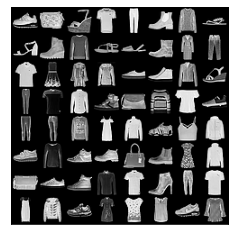

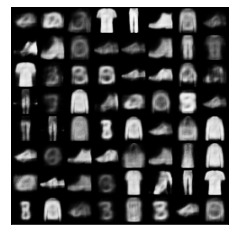

In [ ]:
show_batch(sf_batch)
show_batch(rec_x)

In [ ]:
cult_trainer.train_latent_classifiers([sf_loader, mnist_loader], [fashion_test_loader, mnist_test_loader], ["fashion_mnist", "mnist"], [10, 10], epochs=3, lr=1e-2)

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 0 acc tensor(0.7250)
epoch 1 acc tensor(0.7391)
epoch 2 acc tensor(0.7507)
epoch 3 acc tensor(0.7423)
epoch 4 acc tensor(0.7413)
epoch 0 acc tensor(0.6573)
epoch 1 acc tensor(0.7100)
epoch 2 acc tensor(0.7163)
epoch 3 acc tensor(0.7347)
epoch 4 acc tensor(0.7422)


  3%|▎         | 1/37 [00:20<12:18, 20.51s/it]

epoch 0 acc tensor(0.7470)
epoch 1 acc tensor(0.7463)
epoch 2 acc tensor(0.7580)
epoch 3 acc tensor(0.7670)
epoch 4 acc tensor(0.7630)
epoch 0 acc tensor(0.6988)
epoch 1 acc tensor(0.7343)
epoch 2 acc tensor(0.7589)
epoch 3 acc tensor(0.7702)
epoch 4 acc tensor(0.7737)


  5%|▌         | 2/37 [00:40<11:54, 20.43s/it]

epoch 0 acc tensor(0.7492)
epoch 1 acc tensor(0.7680)
epoch 2 acc tensor(0.7700)
epoch 3 acc tensor(0.7760)
epoch 4 acc tensor(0.7729)
epoch 0 acc tensor(0.7392)
epoch 1 acc tensor(0.7687)
epoch 2 acc tensor(0.7827)
epoch 3 acc tensor(0.7768)
epoch 4 acc tensor(0.7967)


  8%|▊         | 3/37 [01:01<11:35, 20.46s/it]

epoch 0 acc tensor(0.7564)
epoch 1 acc tensor(0.7649)
epoch 2 acc tensor(0.7601)
epoch 3 acc tensor(0.7793)
epoch 4 acc tensor(0.7803)
epoch 0 acc tensor(0.7445)
epoch 1 acc tensor(0.7734)
epoch 2 acc tensor(0.7936)
epoch 3 acc tensor(0.8012)
epoch 4 acc tensor(0.8071)


 11%|█         | 4/37 [01:23<11:31, 20.95s/it]

epoch 0 acc tensor(0.7551)
epoch 1 acc tensor(0.7562)
epoch 2 acc tensor(0.7715)
epoch 3 acc tensor(0.7790)
epoch 4 acc tensor(0.7794)
epoch 0 acc tensor(0.7366)
epoch 1 acc tensor(0.7585)
epoch 2 acc tensor(0.7851)
epoch 3 acc tensor(0.7853)
epoch 4 acc tensor(0.7977)


 14%|█▎        | 5/37 [01:44<11:19, 21.22s/it]

epoch 0 acc tensor(0.7522)
epoch 1 acc tensor(0.7527)
epoch 2 acc tensor(0.7766)
epoch 3 acc tensor(0.7821)
epoch 4 acc tensor(0.7744)
epoch 0 acc tensor(0.7141)
epoch 1 acc tensor(0.7612)
epoch 2 acc tensor(0.7751)
epoch 3 acc tensor(0.7918)
epoch 4 acc tensor(0.7867)


 16%|█▌        | 6/37 [02:05<10:49, 20.95s/it]

epoch 0 acc tensor(0.7492)
epoch 1 acc tensor(0.7649)
epoch 2 acc tensor(0.7559)
epoch 3 acc tensor(0.7743)
epoch 4 acc tensor(0.7802)
epoch 0 acc tensor(0.6989)
epoch 1 acc tensor(0.7352)
epoch 2 acc tensor(0.7641)
epoch 3 acc tensor(0.7775)
epoch 4 acc tensor(0.7887)


 19%|█▉        | 7/37 [02:25<10:21, 20.71s/it]

epoch 0 acc tensor(0.7675)
epoch 1 acc tensor(0.7707)
epoch 2 acc tensor(0.7675)
epoch 3 acc tensor(0.7751)
epoch 4 acc tensor(0.7827)
epoch 0 acc tensor(0.6968)
epoch 1 acc tensor(0.7372)
epoch 2 acc tensor(0.7540)
epoch 3 acc tensor(0.7770)
epoch 4 acc tensor(0.7805)


 22%|██▏       | 8/37 [02:46<10:00, 20.72s/it]

epoch 0 acc tensor(0.7485)
epoch 1 acc tensor(0.7646)
epoch 2 acc tensor(0.7696)
epoch 3 acc tensor(0.7755)
epoch 4 acc tensor(0.7765)
epoch 0 acc tensor(0.6861)
epoch 1 acc tensor(0.7288)
epoch 2 acc tensor(0.7438)
epoch 3 acc tensor(0.7557)
epoch 4 acc tensor(0.7646)


 24%|██▍       | 9/37 [03:06<09:35, 20.55s/it]

epoch 0 acc tensor(0.7498)
epoch 1 acc tensor(0.7672)
epoch 2 acc tensor(0.7709)
epoch 3 acc tensor(0.7694)
epoch 4 acc tensor(0.7801)
epoch 0 acc tensor(0.6688)
epoch 1 acc tensor(0.7066)
epoch 2 acc tensor(0.7298)
epoch 3 acc tensor(0.7344)
epoch 4 acc tensor(0.7524)


 27%|██▋       | 10/37 [03:26<09:13, 20.51s/it]

epoch 0 acc tensor(0.7616)
epoch 1 acc tensor(0.7622)
epoch 2 acc tensor(0.7763)
epoch 3 acc tensor(0.7762)
epoch 4 acc tensor(0.7740)
epoch 0 acc tensor(0.6907)
epoch 1 acc tensor(0.7253)
epoch 2 acc tensor(0.7461)
epoch 3 acc tensor(0.7581)
epoch 4 acc tensor(0.7677)


 30%|██▉       | 11/37 [03:47<08:52, 20.50s/it]

epoch 0 acc tensor(0.7540)
epoch 1 acc tensor(0.7728)
epoch 2 acc tensor(0.7734)
epoch 3 acc tensor(0.7742)
epoch 4 acc tensor(0.7790)
epoch 0 acc tensor(0.6793)
epoch 1 acc tensor(0.7305)
epoch 2 acc tensor(0.7422)
epoch 3 acc tensor(0.7650)
epoch 4 acc tensor(0.7755)


 32%|███▏      | 12/37 [04:07<08:31, 20.45s/it]

epoch 0 acc tensor(0.7560)
epoch 1 acc tensor(0.7618)
epoch 2 acc tensor(0.7690)
epoch 3 acc tensor(0.7751)
epoch 4 acc tensor(0.7715)
epoch 0 acc tensor(0.6463)
epoch 1 acc tensor(0.6972)
epoch 2 acc tensor(0.7232)
epoch 3 acc tensor(0.7365)
epoch 4 acc tensor(0.7459)


 35%|███▌      | 13/37 [04:28<08:14, 20.59s/it]

epoch 0 acc tensor(0.7635)
epoch 1 acc tensor(0.7671)
epoch 2 acc tensor(0.7619)
epoch 3 acc tensor(0.7734)
epoch 4 acc tensor(0.7683)
epoch 0 acc tensor(0.6726)
epoch 1 acc tensor(0.7062)
epoch 2 acc tensor(0.7281)
epoch 3 acc tensor(0.7577)
epoch 4 acc tensor(0.7568)


 38%|███▊      | 14/37 [04:49<07:56, 20.72s/it]

epoch 0 acc tensor(0.7395)
epoch 1 acc tensor(0.7545)
epoch 2 acc tensor(0.7717)
epoch 3 acc tensor(0.7702)
epoch 4 acc tensor(0.7699)
epoch 0 acc tensor(0.6406)
epoch 1 acc tensor(0.6996)
epoch 2 acc tensor(0.7355)
epoch 3 acc tensor(0.7476)
epoch 4 acc tensor(0.7607)


 41%|████      | 15/37 [05:09<07:31, 20.53s/it]

epoch 0 acc tensor(0.7505)
epoch 1 acc tensor(0.7549)
epoch 2 acc tensor(0.7688)
epoch 3 acc tensor(0.7682)
epoch 4 acc tensor(0.7690)
epoch 0 acc tensor(0.6603)
epoch 1 acc tensor(0.6803)
epoch 2 acc tensor(0.7073)
epoch 3 acc tensor(0.7120)
epoch 4 acc tensor(0.7329)


 43%|████▎     | 16/37 [05:29<07:05, 20.27s/it]

epoch 0 acc tensor(0.7334)
epoch 1 acc tensor(0.7575)
epoch 2 acc tensor(0.7704)
epoch 3 acc tensor(0.7656)
epoch 4 acc tensor(0.7721)
epoch 0 acc tensor(0.6729)
epoch 1 acc tensor(0.6964)
epoch 2 acc tensor(0.7257)
epoch 3 acc tensor(0.7301)
epoch 4 acc tensor(0.7425)


 46%|████▌     | 17/37 [05:50<06:49, 20.47s/it]

epoch 0 acc tensor(0.7556)
epoch 1 acc tensor(0.7521)
epoch 2 acc tensor(0.7597)
epoch 3 acc tensor(0.7703)
epoch 4 acc tensor(0.7734)
epoch 0 acc tensor(0.6796)
epoch 1 acc tensor(0.7144)
epoch 2 acc tensor(0.7281)
epoch 3 acc tensor(0.7427)
epoch 4 acc tensor(0.7527)


 49%|████▊     | 18/37 [06:11<06:33, 20.73s/it]

epoch 0 acc tensor(0.7512)
epoch 1 acc tensor(0.7584)
epoch 2 acc tensor(0.7710)
epoch 3 acc tensor(0.7692)
epoch 4 acc tensor(0.7760)
epoch 0 acc tensor(0.6974)
epoch 1 acc tensor(0.7386)
epoch 2 acc tensor(0.7462)
epoch 3 acc tensor(0.7694)
epoch 4 acc tensor(0.7694)


 51%|█████▏    | 19/37 [06:32<06:13, 20.76s/it]

epoch 0 acc tensor(0.7462)
epoch 1 acc tensor(0.7509)
epoch 2 acc tensor(0.7578)
epoch 3 acc tensor(0.7708)
epoch 4 acc tensor(0.7548)
epoch 0 acc tensor(0.7326)
epoch 1 acc tensor(0.7668)
epoch 2 acc tensor(0.7823)
epoch 3 acc tensor(0.7814)
epoch 4 acc tensor(0.7977)


 54%|█████▍    | 20/37 [06:53<05:57, 21.01s/it]

epoch 0 acc tensor(0.7530)
epoch 1 acc tensor(0.7592)
epoch 2 acc tensor(0.7655)
epoch 3 acc tensor(0.7597)
epoch 4 acc tensor(0.7665)
epoch 0 acc tensor(0.7748)
epoch 1 acc tensor(0.7838)
epoch 2 acc tensor(0.8042)
epoch 3 acc tensor(0.8135)
epoch 4 acc tensor(0.8137)


 57%|█████▋    | 21/37 [07:15<05:37, 21.07s/it]

epoch 0 acc tensor(0.7210)
epoch 1 acc tensor(0.7496)
epoch 2 acc tensor(0.7615)
epoch 3 acc tensor(0.7673)
epoch 4 acc tensor(0.7700)
epoch 0 acc tensor(0.7935)
epoch 1 acc tensor(0.8160)
epoch 2 acc tensor(0.8108)
epoch 3 acc tensor(0.8282)
epoch 4 acc tensor(0.8317)


 59%|█████▉    | 22/37 [07:36<05:15, 21.01s/it]

epoch 0 acc tensor(0.7530)
epoch 1 acc tensor(0.7519)
epoch 2 acc tensor(0.7639)
epoch 3 acc tensor(0.7702)
epoch 4 acc tensor(0.7646)
epoch 0 acc tensor(0.8061)
epoch 1 acc tensor(0.8272)
epoch 2 acc tensor(0.8296)
epoch 3 acc tensor(0.8402)
epoch 4 acc tensor(0.8406)


 62%|██████▏   | 23/37 [07:57<04:57, 21.24s/it]

epoch 0 acc tensor(0.7494)
epoch 1 acc tensor(0.7557)
epoch 2 acc tensor(0.7588)
epoch 3 acc tensor(0.7655)
epoch 4 acc tensor(0.7666)
epoch 0 acc tensor(0.8158)
epoch 1 acc tensor(0.8375)
epoch 2 acc tensor(0.8405)
epoch 3 acc tensor(0.8450)
epoch 4 acc tensor(0.8507)


 65%|██████▍   | 24/37 [08:19<04:36, 21.26s/it]

epoch 0 acc tensor(0.7474)
epoch 1 acc tensor(0.7508)
epoch 2 acc tensor(0.7658)
epoch 3 acc tensor(0.7634)
epoch 4 acc tensor(0.7551)
epoch 0 acc tensor(0.8228)
epoch 1 acc tensor(0.8404)
epoch 2 acc tensor(0.8497)
epoch 3 acc tensor(0.8537)
epoch 4 acc tensor(0.8590)


 68%|██████▊   | 25/37 [08:39<04:13, 21.13s/it]

epoch 0 acc tensor(0.7465)
epoch 1 acc tensor(0.7574)
epoch 2 acc tensor(0.7551)
epoch 3 acc tensor(0.7555)
epoch 4 acc tensor(0.7640)
epoch 0 acc tensor(0.8405)
epoch 1 acc tensor(0.8416)
epoch 2 acc tensor(0.8564)
epoch 3 acc tensor(0.8534)
epoch 4 acc tensor(0.8583)


 70%|███████   | 26/37 [09:00<03:51, 21.07s/it]

epoch 0 acc tensor(0.7580)
epoch 1 acc tensor(0.7590)
epoch 2 acc tensor(0.7607)
epoch 3 acc tensor(0.7685)
epoch 4 acc tensor(0.7604)
epoch 0 acc tensor(0.8348)
epoch 1 acc tensor(0.8464)
epoch 2 acc tensor(0.8561)
epoch 3 acc tensor(0.8527)
epoch 4 acc tensor(0.8533)


 73%|███████▎  | 27/37 [09:21<03:29, 20.99s/it]

epoch 0 acc tensor(0.7452)
epoch 1 acc tensor(0.7530)
epoch 2 acc tensor(0.7546)
epoch 3 acc tensor(0.7557)
epoch 4 acc tensor(0.7573)
epoch 0 acc tensor(0.8386)
epoch 1 acc tensor(0.8535)
epoch 2 acc tensor(0.8544)
epoch 3 acc tensor(0.8538)
epoch 4 acc tensor(0.8655)


 76%|███████▌  | 28/37 [09:42<03:08, 20.94s/it]

epoch 0 acc tensor(0.7484)
epoch 1 acc tensor(0.7528)
epoch 2 acc tensor(0.7607)
epoch 3 acc tensor(0.7560)
epoch 4 acc tensor(0.7575)
epoch 0 acc tensor(0.8330)
epoch 1 acc tensor(0.8461)
epoch 2 acc tensor(0.8594)
epoch 3 acc tensor(0.8576)
epoch 4 acc tensor(0.8579)


 78%|███████▊  | 29/37 [10:03<02:48, 21.01s/it]

epoch 0 acc tensor(0.7503)
epoch 1 acc tensor(0.7572)
epoch 2 acc tensor(0.7448)
epoch 3 acc tensor(0.7595)
epoch 4 acc tensor(0.7596)
epoch 0 acc tensor(0.8302)
epoch 1 acc tensor(0.8498)
epoch 2 acc tensor(0.8443)
epoch 3 acc tensor(0.8620)
epoch 4 acc tensor(0.8644)


 81%|████████  | 30/37 [10:24<02:26, 20.88s/it]

epoch 0 acc tensor(0.7466)
epoch 1 acc tensor(0.7461)
epoch 2 acc tensor(0.7510)
epoch 3 acc tensor(0.7502)
epoch 4 acc tensor(0.7573)
epoch 0 acc tensor(0.8359)
epoch 1 acc tensor(0.8518)
epoch 2 acc tensor(0.8607)
epoch 3 acc tensor(0.8622)
epoch 4 acc tensor(0.8661)


 84%|████████▍ | 31/37 [10:44<02:04, 20.68s/it]

epoch 0 acc tensor(0.7284)
epoch 1 acc tensor(0.7456)
epoch 2 acc tensor(0.7381)
epoch 3 acc tensor(0.7536)
epoch 4 acc tensor(0.7449)
epoch 0 acc tensor(0.8461)
epoch 1 acc tensor(0.8555)
epoch 2 acc tensor(0.8615)
epoch 3 acc tensor(0.8656)
epoch 4 acc tensor(0.8713)


 86%|████████▋ | 32/37 [11:04<01:42, 20.59s/it]

epoch 0 acc tensor(0.7463)
epoch 1 acc tensor(0.7482)
epoch 2 acc tensor(0.7496)
epoch 3 acc tensor(0.7506)
epoch 4 acc tensor(0.7522)
epoch 0 acc tensor(0.8421)
epoch 1 acc tensor(0.8573)
epoch 2 acc tensor(0.8619)
epoch 3 acc tensor(0.8647)
epoch 4 acc tensor(0.8655)


 89%|████████▉ | 33/37 [11:25<01:22, 20.53s/it]

epoch 0 acc tensor(0.7321)
epoch 1 acc tensor(0.7359)
epoch 2 acc tensor(0.7469)
epoch 3 acc tensor(0.7477)
epoch 4 acc tensor(0.7566)
epoch 0 acc tensor(0.8488)
epoch 1 acc tensor(0.8612)
epoch 2 acc tensor(0.8665)
epoch 3 acc tensor(0.8750)
epoch 4 acc tensor(0.8718)


 92%|█████████▏| 34/37 [11:45<01:01, 20.57s/it]

epoch 0 acc tensor(0.7311)
epoch 1 acc tensor(0.7312)
epoch 2 acc tensor(0.7486)
epoch 3 acc tensor(0.7428)
epoch 4 acc tensor(0.7501)
epoch 0 acc tensor(0.8472)
epoch 1 acc tensor(0.8639)
epoch 2 acc tensor(0.8728)
epoch 3 acc tensor(0.8702)
epoch 4 acc tensor(0.8742)


 95%|█████████▍| 35/37 [12:06<00:41, 20.65s/it]

epoch 0 acc tensor(0.7377)
epoch 1 acc tensor(0.7413)
epoch 2 acc tensor(0.7509)
epoch 3 acc tensor(0.7527)
epoch 4 acc tensor(0.7590)
epoch 0 acc tensor(0.8558)
epoch 1 acc tensor(0.8709)
epoch 2 acc tensor(0.8773)
epoch 3 acc tensor(0.8841)
epoch 4 acc tensor(0.8790)


 97%|█████████▋| 36/37 [12:27<00:20, 20.61s/it]

epoch 0 acc tensor(0.7304)
epoch 1 acc tensor(0.7428)
epoch 2 acc tensor(0.7351)
epoch 3 acc tensor(0.7471)
epoch 4 acc tensor(0.7506)
epoch 0 acc tensor(0.8550)
epoch 1 acc tensor(0.8721)
epoch 2 acc tensor(0.8745)
epoch 3 acc tensor(0.8771)
epoch 4 acc tensor(0.8811)


100%|██████████| 37/37 [12:47<00:00, 20.75s/it]


In [ ]:
mnist_test_batch, _labels = iter(mnist_test_loader).next()
fashion_test_batch, _labels = iter(fashion_test_loader).next()
with torch.no_grad():
    _, _, final_mnist = cult_trainer.model.encoder(mnist_test_batch)
    _, _, final_fashion = cult_trainer.model.encoder(fashion_test_batch)
    mnist_logits = cult_trainer.model.env_net(final_mnist)
    fashion_logits = cult_trainer.model.env_net(final_fashion)

mnist_acc = (torch.argmax(mnist_logits, dim=1) == 1).sum() / mnist_logits.shape[0]
fashion_acc = (torch.argmax(fashion_logits, dim=1) == 0).sum() / fashion_logits.shape[0]
mnist_acc, fashion_acc

(tensor(1.), tensor(0.1406))